In [1]:
# %matplotlib qt
# %matplotlib ipympl

In [2]:
## Imports
print("Importing...")
import re
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import easyocr

from matplotlib.backends.backend_pdf import PdfPages
from recognizer_modules import PreProcessor, PostProcessor


Importing...


In [3]:
## Inputs
VIDEO_PATH = r"Examples\Test\Test_window.avi"
# VIDEO_PATH = None
rules = dict(re_rule=r'-?\d{1,3}\.\d', )
variable_patterns = {'Viscosity': rules, 'Temperature': rules}

Configurate image processing


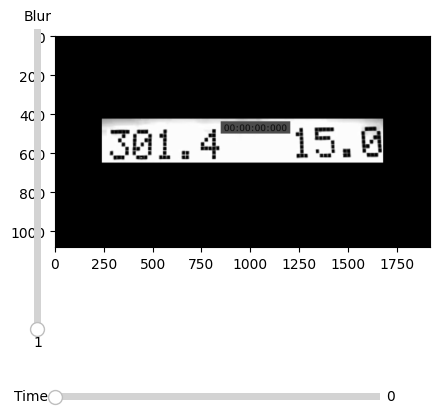

Press:
   Enter - save selection and continue
   R     - reset video timer
   Ecs/C - cancel selection
113
101
113
101
101
0
0
0
0
99
13
99
13


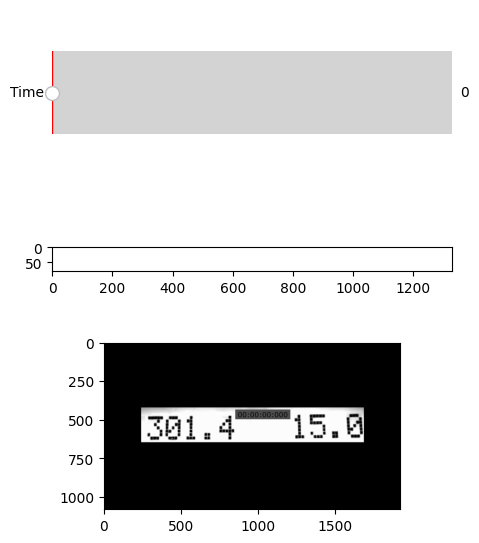

In [5]:
## PreProcessor settings
class ImagePreProcessor(PreProcessor):
    Blur = range(1, 50)

    def process(self, image, gray_image=True):
        image = cv2.blur(image, (int(self['Blur']), int(self['Blur'])))
        if gray_image:
            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            except:
                pass
            image = cv2.bitwise_not(image)

        return image


if VIDEO_PATH is None:
    input_path = ''
    while input_path == '':
        input_path = input(f"Input video path: ")
    VIDEO_PATH = input_path

CAP = cv2.VideoCapture(VIDEO_PATH)
FPS = int(CAP.get(cv2.CAP_PROP_FPS))
LENTH = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / FPS)
CAP.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, START_FRAME = CAP.read()

processor = ImagePreProcessor([i for i in variable_patterns])
print('Configurate image processing')
processor.configure_process(CAP)
print(
    'Press:',
    '   Enter - save selection and continue',
    '   R     - reset video timer',
    '   Ecs/C - cancel selection',
    sep='\n',
)
processor.select_window(CAP)
processor.check_process(CAP)


In [ ]:
## PostProcessor settings
class ValuePostProcessor(PostProcessor):

    def pattern(
        self,
        value: list,
        re_rule=None,
        min_rule=None,
        max_rule=None,
    ) -> float|None:

        if value == []: return None
        value = value[0]
        value = value.replace(',', '.')
        regexp_cond = len(re.findall(re_rule, value)) == 1
        try:
            value = float(value)
        except ValueError:
            return None
        min_cond = value <= min_rule if min_rule is not None else True
        max_cond = value >= max_rule if max_rule is not None else True

        return value if regexp_cond and min_cond and max_cond else None

    @PostProcessor._check_type
    def processor_sweep(self) -> list[str]:
        for i in range(1, 20):
            self.inner_processor['Blur'] = i
            processed_img = self.inner_processor(self._image)
            raw_value = [
                value for _, value, _ in self._reader.readtext(processed_img)
            ]

            result = self.pattern(raw_value, **self._rules)
            if result is not None: return raw_value
        return []

    @PostProcessor._check_type
    def value_combine(self) -> list[str]:
        parts = len(self._raw_value)
        if parts == 1:
            value = self._raw_value[0]
            result = value[:3] + '.' + value[4:5]

        elif parts == 2:
            result = '.'.join(self._raw_value)

        elif parts == 3:
            result = f'{self._raw_value[0]}.{self._raw_value[2]}'

        return [result]


print('Starting recognizer...')
reader = easyocr.Reader(['en'])
checker = ValuePostProcessor(reader=reader, processor=processor)
print([i for i in checker.all_checks])
# checker.active_checks_order = {check:checker.all_checks[check] for check in ['inner_processor_check','value_combine']}

In [ ]:
## Recognize
input_fps = input('Input number of frames per second: ')
try:
    read_fps = float(input_fps)
except:
    read_fps = 1

print('Recognizing:')
errors = 0
frame_line = tqdm(iterable=range(0, FPS * LENTH, int(FPS / read_fps)))
frame_line.set_description(f'Errors: {errors: >4}')
data = []

for i_frame in frame_line:
    CAP.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    _, frame = CAP.read()
    i_text = {'time': round(i_frame / FPS, 1)}
    processed_frame = processor(frame)
    stricted_images = processor.strict(processed_frame)

    for var, rules in variable_patterns.items():
        var_image = stricted_images[var]
        raw_value = [value for _, value, _ in reader.readtext(var_image)]

        mark, result = checker.check(image=var_image,
                               raw_value=raw_value,
                               rules=rules)
        if mark == 'error':
            processor.configure_process(CAP,start_frame=i_frame)
            processor.select_window(CAP,start_frame=i_frame)
            processor.check_process(CAP,start_frame=i_frame)
            checker.reload_processor(processor)
            mark, result = checker.check(image=var_image,
                        raw_value=raw_value,
                        rules=rules)
            mark= f'*{mark}'
        i_text[var] = result
        i_text[var + '_verbose'] = mark

    if None in i_text.values():
        errors += 1
        frame_line.set_description(f'Errors: {errors: >4}')
    data.append(i_text)


In [ ]:
## Print
print(pd.DataFrame(data))